In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from enum import Enum
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/cdrive')
data_root_dir = 'cdrive/MyDrive/Deep Learning/HW1/'

Drive already mounted at /content/cdrive; to attempt to forcibly remount, call drive.mount("/content/cdrive", force_remount=True).


## Network Architecture

In [ ]:
class RegType(Enum):
  """
  Objects of Class RegType will denote the used regularization method
  """
  NONE=1
  DROPOUT=2
  WDECAY=3
  BATCHNORM=4

class LeNet5(nn.Module):
  """
  class LeNet5 implements the LeNet5 NN model for MNIST/FashionMNIST dataset.
  """
  def __init__(self, n_classes=10, reg_type: RegType=RegType.NONE, p_dropout=0.5):
    """
    Initialize a new LeNet5 model based on input params
    : param n_classes : integer defining number of classification classes. default is 10
    : param reg_type : RegType enumerated type - defining the regularization method used in the model layers. default is RegType.NONE
    : param p_dropout : float defining the dropout probability in case of using RegType.DROPOUT regularization method. otherwise it is meaningless. default is 0.5
    """
    super().__init__()
    self.reg_type = reg_type

    if reg_type in [RegType.NONE, RegType.WDECAY]:
      self.layers = nn.ModuleList([
          nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=5, padding='same'), nn.Tanh(), nn.AvgPool2d(kernel_size=2, stride=2),
          nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.Tanh(), nn.AvgPool2d(kernel_size=2, stride=2),
          nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5), nn.Tanh(),
          nn.Flatten(),
          nn.Linear(in_features=120, out_features=84), nn.Tanh(),
          nn.Linear(in_features=84, out_features=n_classes),
          nn.LogSoftmax(dim=-1),
      ])

    elif reg_type == RegType.BATCHNORM:
      self.layers = nn.ModuleList([
          nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=5, padding='same'), nn.BatchNorm2d(6), nn.Tanh(), nn.AvgPool2d(kernel_size=2, stride=2),
          nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.BatchNorm2d(16), nn.Tanh(), nn.AvgPool2d(kernel_size=2, stride=2),
          nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5), nn.Flatten(), nn.BatchNorm1d(120), nn.Tanh(),
          nn.Linear(in_features=120, out_features=84), nn.BatchNorm1d(84), nn.Tanh(),
          nn.Linear(in_features=84, out_features=n_classes),
          nn.LogSoftmax(dim=-1),
      ])

    elif reg_type == RegType.DROPOUT:
      self.layers = nn.ModuleList([
          nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=5, padding='same'), nn.Tanh(), nn.AvgPool2d(kernel_size=2, stride=2),
          nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.Tanh(), nn.AvgPool2d(kernel_size=2, stride=2),
          nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5), nn.Tanh(),
          nn.Flatten(),
          nn.Linear(in_features=120, out_features=84), nn.Tanh(), nn.Dropout(p_dropout),
          nn.Linear(in_features=84, out_features=n_classes),
          nn.LogSoftmax(dim=-1),
      ])

  def forward(self, x):
    """
    model forward pass function - implemented by iteratively applying model layers one by another.
    """
    for layer in self.layers:
      x = layer(x)
    return x


## Dataset & DataLoader

In [ ]:
n_epochs = 50
batch_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor()])

# datasets
trainset = datasets.FashionMNIST(root=data_root_dir, train=True, download=True, transform=transform)
evalset = datasets.FashionMNIST(root=data_root_dir, train=False, download=True, transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
eval_loader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)


## Training Loop

In [ ]:
def train_lenet(model: LeNet5, opt, loss):
  """
  def train_lenet(model: LeNet5, opt, loss):
    : param model : LeNet5 - model to be trained
    : param opt : optimizer to be used
    : loss : loss function for optimization objective

    : return : Tuple[List[float], List[float]] - a tuple of two lists for training & test accuracies per model epoch
  """
  train_accs = []
  test_accs = []

  for e in range(n_epochs):
    total_loss = 0
    n_train_corrects = 0
    for Xi, Yi in trainloader:
      Xi, Yi = Xi.to(device), Yi.to(device)

      # train step
      yhat = model(Xi)
      loss = criterion(yhat, Yi)
      total_loss += loss.item()

      opt.zero_grad()
      loss.backward()
      opt.step()

      # in-training evalation
      # disable dropout/batchnorm for train accuracy evaluation
      model.eval()
      with torch.no_grad():
        yhat = model(Xi)
        n_train_corrects += torch.sum(yhat.argmax(dim=-1)==Yi).item()
      model.train()

    # Evaluation
    n_test_corrects = 0
    model.eval()
    with torch.no_grad():
      for Xi, Yi in eval_loader:
        Xi, Yi = Xi.to(device), Yi.to(device)
        yhat = model(Xi)
        n_test_corrects += torch.sum(yhat.argmax(dim=-1)==Yi).item()
    model.train()

    L = total_loss / len(trainset)
    train_accs.append(100. * n_train_corrects / len(trainset))
    test_accs.append(100.* n_test_corrects / len(evalset))
    if e % 5 == 0 or e == n_epochs - 1: print(f'Epoch #{e}, Loss={L:.5f}, Train accuracy={(train_accs[-1]):.3f}%, Test accuracy={(test_accs[-1]):.3f}%')

  return train_accs, test_accs

## Regularization

### Vanilla

In [ ]:
vanilla_model = LeNet5().to(device)
opt = optim.Adam(vanilla_model.parameters(), lr=1e-3)

criterion = nn.NLLLoss()

vanilla_train_acc, vanilla_test_acc = train_lenet(vanilla_model, opt, criterion)

# save model weights
torch.save(vanilla_model.state_dict(), data_root_dir + 'saved_models/vanilla_model')

Epoch #0, Loss=0.00945, Train accuracy=78.317%, Test accuracy=82.940%
Epoch #5, Loss=0.00452, Train accuracy=89.812%, Test accuracy=87.660%
Epoch #10, Loss=0.00363, Train accuracy=91.915%, Test accuracy=88.870%
Epoch #15, Loss=0.00301, Train accuracy=93.402%, Test accuracy=89.450%
Epoch #20, Loss=0.00250, Train accuracy=94.740%, Test accuracy=89.120%
Epoch #25, Loss=0.00206, Train accuracy=95.835%, Test accuracy=89.360%
Epoch #30, Loss=0.00172, Train accuracy=96.690%, Test accuracy=89.290%
Epoch #35, Loss=0.00137, Train accuracy=97.567%, Test accuracy=89.020%
Epoch #40, Loss=0.00113, Train accuracy=98.227%, Test accuracy=88.790%
Epoch #45, Loss=0.00091, Train accuracy=98.652%, Test accuracy=89.290%
Epoch #49, Loss=0.00081, Train accuracy=98.907%, Test accuracy=88.710%


### Dropout

In [ ]:
dropout_model = LeNet5(reg_type=RegType.DROPOUT).to(device)
opt = optim.Adam(dropout_model.parameters(), lr=1e-3)

criterion = nn.NLLLoss()

dropout_train_acc, dropout_test_acc = train_lenet(dropout_model, opt, criterion)

# save model weights
torch.save(dropout_model.state_dict(), data_root_dir + "saved_models/dropout_model")

Epoch #0, Loss=0.01091, Train accuracy=76.353%, Test accuracy=80.740%
Epoch #5, Loss=0.00522, Train accuracy=89.198%, Test accuracy=87.300%
Epoch #10, Loss=0.00427, Train accuracy=91.258%, Test accuracy=88.560%
Epoch #15, Loss=0.00364, Train accuracy=92.717%, Test accuracy=89.210%
Epoch #20, Loss=0.00321, Train accuracy=93.792%, Test accuracy=89.520%
Epoch #25, Loss=0.00282, Train accuracy=94.743%, Test accuracy=89.290%
Epoch #30, Loss=0.00243, Train accuracy=95.667%, Test accuracy=89.810%
Epoch #35, Loss=0.00214, Train accuracy=96.297%, Test accuracy=89.360%
Epoch #40, Loss=0.00190, Train accuracy=97.003%, Test accuracy=89.330%
Epoch #45, Loss=0.00165, Train accuracy=97.457%, Test accuracy=89.160%
Epoch #49, Loss=0.00150, Train accuracy=97.858%, Test accuracy=89.020%


### Weight Decay

In [ ]:
wdecay_model = LeNet5(reg_type=RegType.WDECAY).to(device) # effectively WDECAY & NONE have same architecture...
opt = optim.Adam(wdecay_model.parameters(), lr=1e-3, weight_decay=1e-4)

criterion = nn.NLLLoss()

wdecay_train_acc, wdecay_test_acc = train_lenet(wdecay_model, opt, criterion)

# save model weights
torch.save(wdecay_model.state_dict(), data_root_dir + "saved_models/wdecay_model")

Epoch #0, Loss=0.00935, Train accuracy=78.710%, Test accuracy=83.040%
Epoch #5, Loss=0.00450, Train accuracy=89.933%, Test accuracy=87.790%
Epoch #10, Loss=0.00363, Train accuracy=91.933%, Test accuracy=88.390%
Epoch #15, Loss=0.00306, Train accuracy=93.387%, Test accuracy=89.220%
Epoch #20, Loss=0.00261, Train accuracy=94.587%, Test accuracy=89.520%
Epoch #25, Loss=0.00227, Train accuracy=95.385%, Test accuracy=90.000%
Epoch #30, Loss=0.00196, Train accuracy=96.263%, Test accuracy=89.840%
Epoch #35, Loss=0.00169, Train accuracy=96.927%, Test accuracy=89.410%
Epoch #40, Loss=0.00149, Train accuracy=97.473%, Test accuracy=88.690%
Epoch #45, Loss=0.00128, Train accuracy=97.975%, Test accuracy=89.560%
Epoch #49, Loss=0.00123, Train accuracy=98.145%, Test accuracy=89.700%


### BatchNorm

In [ ]:
batchnorm_model = LeNet5(reg_type=RegType.BATCHNORM).to(device)
opt = optim.Adam(batchnorm_model.parameters(), lr=1e-3)

criterion = nn.NLLLoss()

batchnorm_train_acc, batchnorm_test_acc = train_lenet(batchnorm_model, opt, criterion)

# save model weights
torch.save(batchnorm_model.state_dict(), data_root_dir + "saved_models/batchnorm_model")

Epoch #0, Loss=0.00724, Train accuracy=84.513%, Test accuracy=85.550%
Epoch #5, Loss=0.00364, Train accuracy=91.778%, Test accuracy=90.300%
Epoch #10, Loss=0.00272, Train accuracy=94.017%, Test accuracy=90.110%
Epoch #15, Loss=0.00206, Train accuracy=95.797%, Test accuracy=91.100%
Epoch #20, Loss=0.00157, Train accuracy=96.810%, Test accuracy=90.880%
Epoch #25, Loss=0.00128, Train accuracy=97.707%, Test accuracy=91.130%
Epoch #30, Loss=0.00097, Train accuracy=98.305%, Test accuracy=91.030%
Epoch #35, Loss=0.00080, Train accuracy=98.837%, Test accuracy=90.380%
Epoch #40, Loss=0.00068, Train accuracy=99.133%, Test accuracy=90.240%
Epoch #45, Loss=0.00061, Train accuracy=99.160%, Test accuracy=90.820%
Epoch #49, Loss=0.00053, Train accuracy=99.375%, Test accuracy=90.560%


## Convergence Plots

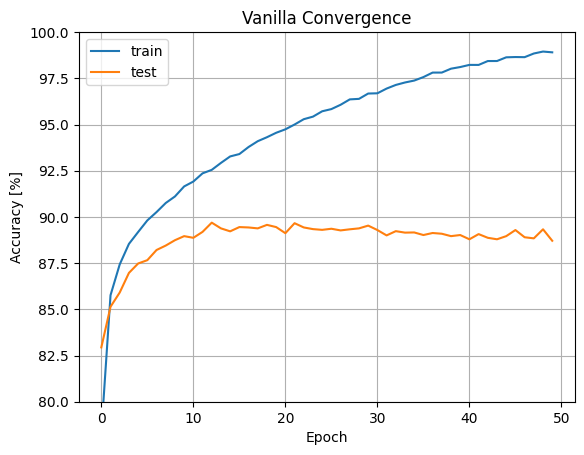

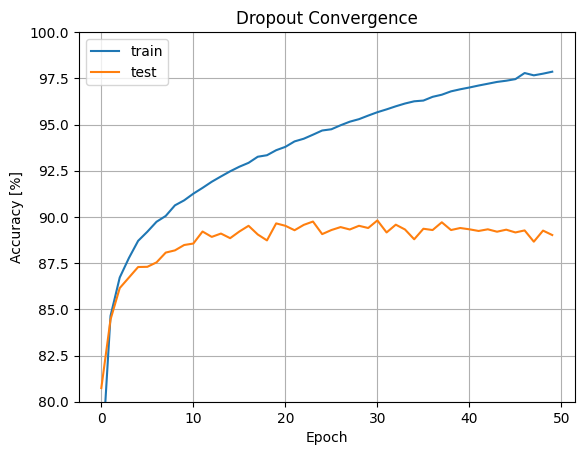

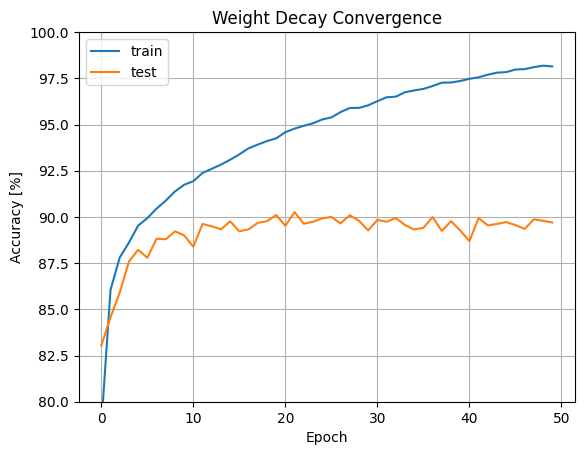

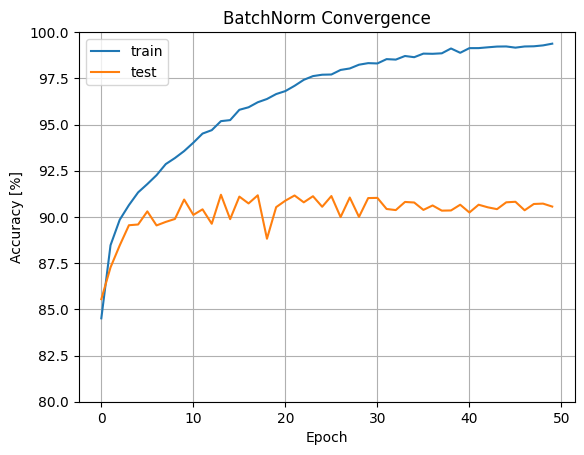

In [ ]:
from matplotlib import pyplot as plt
from typing import List

def plot_model_convergence(train_accs: List[float],
                           test_accs: List[float],
                           model_name: str):
  """
  plot_model_convergence(train_accs: List[float], test_accs: List[float], model_name: str):
    : param train_accs : List[float] - a list of training accuracies
    : param test_accs : List[float] - a list of test accuracies
    : param model_name : str - model name for plot title

  """
  plt.plot(train_accs, label='train')
  plt.plot(test_accs, label='test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy [%]')
  plt.title(f'{model_name} Convergence')
  plt.ylim(80, 100)
  plt.grid()
  plt.legend()
  plt.show()

plot_model_convergence(vanilla_train_acc, vanilla_test_acc, "Vanilla")
plot_model_convergence(dropout_train_acc, dropout_test_acc, "Dropout")
plot_model_convergence(wdecay_train_acc, wdecay_test_acc, "Weight Decay")
plot_model_convergence(batchnorm_train_acc, batchnorm_test_acc, "BatchNorm")


In [ ]:
import pandas as pd

final_res = pd.DataFrame([
                          [vanilla_train_acc[-1], dropout_train_acc[-1], wdecay_train_acc[-1], batchnorm_train_acc[-1]],
                          [vanilla_test_acc[-1],  dropout_test_acc[-1],  wdecay_test_acc[-1],  batchnorm_test_acc[-1]]],
                         columns=['Vanilla', 'Dropout', 'Weight Decay', 'Batch Norm'],
                         index=['Training Accuracy', 'Test Accuracy'])

print(final_res)

                     Vanilla    Dropout  Weight Decay  Batch Norm
Training Accuracy  98.906667  97.858333        98.145      99.375
Test Accuracy      88.710000  89.020000        89.700      90.560


## Testing Saved Models


In [ ]:
# utility functions
def get_accuracy(model: LeNet5, data_loader, device):
  """
  evaluate model accuracy for a given dataset through its dataloader

  get_accuracy(model: LeNet5, data_loader, device):
    : param model : LeNet5 trained model to evaluate
    : prarm data_loader: torch dataloader holding the data for evaluation
    : param device : used to pass the data to the device on which the model is currently loaded

    : return :  model accuracy over the data
  """
    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            predicted_labels = torch.max(y_prob, 1)
            n += y_true.size(0)
            correct_pred += (predicted_labels[1] == y_true).sum()

    return 100*correct_pred.float() / n

def load_inference_model(reg_type: RegType=RegType.NONE):
  """
  def load_inference_model(reg_type: RegType=RegType.NONE)
  : param reg_type : RegType enumeated type used to choose which model to load from our saved models directory

  : return : LeNet5 trained model
  """
  model = LeNet5(reg_type=reg_type).to(device)
  if reg_type is RegType.NONE:
    PATH = data_root_dir + "saved_models/vanilla_model"
  elif reg_type is RegType.DROPOUT:
    PATH = data_root_dir + "saved_models/dropout_model"
  elif reg_type is RegType.WDECAY:
    PATH = data_root_dir + "saved_models/wdecay_model"
  elif reg_type is RegType.BATCHNORM:
    PATH = data_root_dir + "saved_models/batchnorm_model"
  else:
    raise ValueError

  model.load_state_dict(torch.load(PATH))
  return model


### vanilla model

In [ ]:
vanilla_inference_model = load_inference_model(RegType.NONE)
vanilla_acc = get_accuracy(vanilla_inference_model, eval_loader, device)
print(f"Vanilla model Accuracy: {vanilla_acc:.3f}%")

Vanilla model Accuracy: 88.710%


### dropout model

In [ ]:
dropout_inference_model = load_inference_model(RegType.DROPOUT)
dropout_acc = get_accuracy(dropout_inference_model, eval_loader, device)
print(f"Dropout model Accuracy: {dropout_acc:.3f}%")

Dropout model Accuracy: 89.020%


### weight decay model

In [ ]:
wdecay_inference_model = load_inference_model(RegType.WDECAY)
wdecay_acc = get_accuracy(wdecay_inference_model, eval_loader, device)
print(f"Weight-Decay model Accuracy: {wdecay_acc:.3f}%")

Weight-Decay model Accuracy: 89.700%


### batch normalization model

In [ ]:
batchnorm_inference_model = load_inference_model(RegType.BATCHNORM)
batchnorm_acc = get_accuracy(batchnorm_inference_model, eval_loader, device)
print(f"BatchNorm model Accuracy: {batchnorm_acc:.3f}%")

BatchNorm model Accuracy: 90.560%
